Loading intrinsic population
Loading GW population
Loading EM population (GRB afterglow)

EoS: SFHo
Population model: A
The mass and spin distributions are NOT fixed
The spin prescription is: Zero

Computing GRB AFTERGLOW limiting thresholds
Saturation rates ETT GRB Afterglow: 347.13148560961014
Saturation rates ETT GRB Afterglow: 347.13148560961014
Saturation rates ETT GRB Afterglow: 347.13148560961014
Computing GRB AFTERGLOW limiting thresholds
Computing GRB AFTERGLOW limiting thresholds
Computing GRB AFTERGLOW limiting thresholds


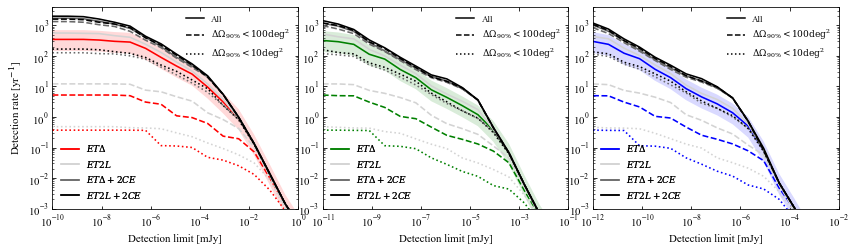

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tabulate import tabulate
import h5py
from astropy.cosmology import Planck18 as cosmo
from astropy.cosmology import z_at_value
import astropy.units as u
import scipy
from scipy import stats
from scipy.integrate import cumtrapz
from scipy.ndimage import gaussian_filter as gf
from matplotlib.lines import Line2D
import pandas
import corner
import sympy as sp
import os
from scipy.interpolate import RegularGridInterpolator
import matplotlib.gridspec as gridspec
from functions_ET import * 
import sys
sys.path.insert(0, '../code')
from Prompt_GRB.spectrum import photon_flux
sys.path.insert(0, '../COMPAS')
from spin_class import * 
import warnings
warnings.filterwarnings("ignore")

num = 1000000
eos = "SFHo"
mns_max = 2.058882

table = h5py.File('../horizons2/population/computed_population/bhns_%i_%s_z10_mass_spin_thv_GWFAST_ET.hdf5' %(num,eos),'r')

DCOtype='BHNS'
poptype='A'
path = '../horizons2/importance_sampling/mass_rate/ET_COMPASCompactOutput_'+ DCOtype + '_' + poptype+'.h5' # change this line! 

distribution = 'NOT fixed' #or 'NOT fixed'

spin_prescription = 'Zero' #/Qin21/Uniform/Bavera21

if poptype == 'A':
    w_type='w_000'
    r0 = 94
    w_type_high = 'w_000' #w_231
    r0_high = 203
    w_type_low = 'w_000' #w_312
    r0_low = 30
    
if poptype == 'B':
    w_type='w_000'
    r0 = 20
    w_type_high = 'w_000' #w_231
    r0_high = 100
    w_type_low = 'w_312' #w_312
    r0_low = 10


### --- Loading Population --- ###

print("Loading intrinsic population")
mbh = table['mbh'][()]
mns = table['mns'][()]
lamb_ns = table['lamb_ns'][()]
spin_bh = table['spin_bh'][()]
#i_tilt = table['i_tilt'][()]
z = table['z'][()]
dL = table['dL'][()]
thv = table['thv'][()]
ra = table['ra'][()]
dec = table['dec'][()]
#pol = table['pol'][()]
m_dyn = table['m_dyn'][()]
v_dyn = table['v_dyn'][()]
m_disk = table['m_disk'][()]
m_out = table['m_out'][()]
final_x = table['final_x'][()]
E_bkt = table['E_bkt'][()]
E_k_jet = table['E_k_jet'][()]
Ec = table['Ec'][()]

print("Loading GW population")

snr_ETT2CE = table['snr_ETT2CE'][()]
snr_ETT = table['snr_ETT'][()]
sky_loc_ETT2CE = table['sky_loc_ETT2CE'][()]
sky_loc_ETT = table['sky_loc_ETT'][()]

snr_ETL2CE = table['snr_ETL2CE'][()]
snr_ETL = table['snr_ETL'][()]
sky_loc_ETL2CE = table['sky_loc_ETL2CE'][()]
sky_loc_ETL = table['sky_loc_ETL'][()]

#snr_ETT_net = table['snr_ETT_net'][()] #old data with 100% duty cycle
#sky_loc_ETT_net = table['sky_loc_ETT_net'][()] #old data with 100% duty cycle

print("Loading EM population (GRB afterglow)")
grb_nu = table['grb_nu'][()]
t_grb = table['t_grb'][()]
th = table['th'][()]
lc_grb = table['lc_grb'][()]
table.close()

### --- Weights --- ###

np.random.seed(0)
spin = calculate_spin_olderCOMPASdata(data_path=path)
if spin_prescription == 'Bavera21':
    spinM1, spinM2  = spin.Bavera21()
if spin_prescription == 'Qin21':
    spinM1, spinM2  = spin.Qin21()
if spin_prescription == 'Uniform':
    spinM1, spinM2  = spin.Bavera21()
    spinM1 = np.random.uniform(0.,0.5,spinM1.shape)
    spinM2 = np.random.uniform(0.,0.5,spinM2.shape)
elif spin_prescription == 'Zero':
    spinM1, spinM2  = spin.Bavera21()
    spinM1 = np.random.uniform(0.,0.,spinM1.shape)
    spinM2 = np.random.uniform(0.,0.,spinM2.shape)

#bhx=[1.5,27]
#nsx=[0.9,3]
#spinx=[-0.1,1.1]
bhx=[2.5,27]
nsx=[1.1,3]
spinx=[0.,1.]
binsx=50
binsy=50
binsz=50
 
if distribution == 'NOT fixed':
    table_w = h5py.File('../horizons2/population/computed_population/weight/w_bhns_%s_%s_notfixed.hdf5' %(eos,spin_prescription),'r')
    #read
    C_mc = table_w['C_mc'][()]
    C_mc_low = table_w['C_mc_low'][()]
    C_mc_high = table_w['C_mc_high'][()]
    w = table_w['w'][()]
    w_low = table_w['w_low'][()]
    w_high = table_w['w_high'][()]   
    table_w.close()

print("")
print("EoS:",eos)
print("Population model:",poptype)
print("The mass and spin distributions are", distribution)
if distribution == 'fixed':
    print("The fiducial SFRD is", w_type, "with r0 =", r0)
    print("The higher limit SFRD is", w_type_high, "with r0 =", r0_high)
    print("The lower limit SFRD is", w_type_low, "with r0 =", r0_low)
print("The spin prescription is:", spin_prescription)
print("")


### --- Limiting Thresholds --- ###
lim_snr =12.

lim_grb_radio = np.logspace(-10,2,20)
lim_grb_optic = np.logspace(-11,1,20)
lim_grb_x = np.logspace(-12,0,20)
det_grb_radio = np.zeros(len(lim_grb_radio))
det_grb_radio_high = np.zeros(len(lim_grb_radio))
det_grb_radio_low = np.zeros(len(lim_grb_radio))
det_grb_radio_100 = np.zeros(len(lim_grb_radio))
det_grb_radio_10 = np.zeros(len(lim_grb_radio))
det_grb_optic = np.zeros(len(lim_grb_optic))
det_grb_optic_high = np.zeros(len(lim_grb_optic))
det_grb_optic_low = np.zeros(len(lim_grb_optic))
det_grb_x = np.zeros(len(lim_grb_x))
det_grb_x_high = np.zeros(len(lim_grb_x))
det_grb_x_low = np.zeros(len(lim_grb_x))
det_grb_optic_100 = np.zeros(len(lim_grb_optic))
det_grb_x_100 = np.zeros(len(lim_grb_x))
det_grb_optic_10 = np.zeros(len(lim_grb_optic))
det_grb_x_10 = np.zeros(len(lim_grb_x))
det_radio = np.zeros(len(lim_grb_radio))
det_optic = np.zeros(len(lim_grb_optic))
det_x = np.zeros(len(lim_grb_x))
det_optic_100 = np.zeros(len(lim_grb_optic))
det_x_100 = np.zeros(len(lim_grb_x))
det_optic_10 = np.zeros(len(lim_grb_optic))
det_x_10 = np.zeros(len(lim_grb_x))
det_grb_radio_15 = np.zeros(len(lim_grb_radio))
det_grb_optic_15 = np.zeros(len(lim_grb_optic))
det_grb_x_15 = np.zeros(len(lim_grb_x))
det_radio_15 = np.zeros(len(lim_grb_radio))
det_optic_15 = np.zeros(len(lim_grb_optic))
det_x_15 = np.zeros(len(lim_grb_x))

x = np.sort(z)
s = np.argsort(z)

snr = [snr_ETT, snr_ETL, snr_ETT2CE, snr_ETL2CE]
sky = [sky_loc_ETT, sky_loc_ETL, sky_loc_ETT2CE, sky_loc_ETL2CE]
color_x = ['b','lightgrey','dimgrey','black']
color_optic = ['green','lightgrey','dimgrey','black']
color_radio = ['red','lightgrey','dimgrey','black']

#recomp_gaussian = False
#recomp_uniform = False
plt.rcParams['font.family']="Times New Roman"
#plt.rcParams['font.size'] = 11
plt.rcParams['figure.figsize']=12., 3.5
#plt.rcParams['figure.autolayout']=True
plt.rcParams['mathtext.fontset']='dejavuserif'
#plt.rcParams["axes.axisbelow"] = False

gs = gridspec.GridSpec(1,3,top=0.95,right=0.98,left=0.07,wspace=0.1,hspace=0.1,bottom=0.15)  

for k in range(0,len(snr)):
    gw_snr = snr[k]
    sky_loc = sky[k]
    gw_det = gw_snr >= lim_snr
    
    cum_gw = C_mc*np.cumsum(w[s]*gw_det[s])
 
    #GRB AFTERGLOW
    print("Computing GRB AFTERGLOW limiting thresholds")
    grb_peak = np.max(lc_grb, axis=2)
    grb_det = np.zeros([num,len(grb_nu)],dtype=bool)
    grb_det_15 = np.zeros([num,len(grb_nu)],dtype=bool)
    for i in range(len(lim_grb_x)):
        grb_det[:,0] = grb_peak[:,0,0] >= lim_grb_radio[i]
        grb_det[:,1] = grb_peak[:,1,0] >= lim_grb_optic[i]
        grb_det[:,2] = grb_peak[:,2,0] >= lim_grb_x[i]
        grb_det_radio = grb_det[:,0]
        grb_det_optic = grb_det[:,1]
        grb_det_x = grb_det[:,2]
        cum_gw_grb_radio =  C_mc*np.cumsum(w[s]*grb_det_radio[s]*gw_det[s]*(m_disk[s]>1.e-5)) 
        cum_gw_grb_radio_high =  C_mc_high *np.cumsum(w_high[s]*grb_det_radio[s]*gw_det[s]*(m_disk[s]>1.e-5)) 
        cum_gw_grb_radio_low =  C_mc_low*np.cumsum(w_low[s]*grb_det_radio[s]*gw_det[s]*(m_disk[s]>1.e-5))    
        cum_gw_grb_radio_100 =  C_mc*np.cumsum(w[s]*grb_det_radio[s]*gw_det[s]*(sky_loc[s]<100.)*(m_disk[s]>1.e-5)) 
        cum_gw_grb_radio_10 =  C_mc*np.cumsum(w[s]*grb_det_radio[s]*gw_det[s]*(sky_loc[s]<10.)*(m_disk[s]>1.e-5))     
        cum_gw_grb_optic =  C_mc*np.cumsum(w[s]*grb_det_optic[s]*gw_det[s]*(m_disk[s]>1.e-5))
        cum_gw_grb_optic_high =  C_mc_high*np.cumsum(w_high[s]*grb_det_optic[s]*gw_det[s]*(m_disk[s]>1.e-5)) 
        cum_gw_grb_optic_low =  C_mc_low*np.cumsum(w_low[s]*grb_det_optic[s]*gw_det[s]*(m_disk[s]>1.e-5))  
        cum_gw_grb_optic_100 =  C_mc*np.cumsum(w[s]*grb_det_optic[s]*gw_det[s]*(sky_loc[s]<100.)*(m_disk[s]>1.e-5))  
        cum_gw_grb_optic_10 =  C_mc*np.cumsum(w[s]*grb_det_optic[s]*gw_det[s]*(sky_loc[s]<10.)*(m_disk[s]>1.e-5))    
        cum_gw_grb_x =  C_mc*np.cumsum(w[s]*grb_det_x[s]*gw_det[s]*(m_disk[s]>1.e-5))
        cum_gw_grb_x_high =  C_mc_high*np.cumsum(w_high[s]*grb_det_x[s]*gw_det[s]*(m_disk[s]>1.e-5)) 
        cum_gw_grb_x_low =  C_mc_low*np.cumsum(w_low[s]*grb_det_x[s]*gw_det[s]*(m_disk[s]>1.e-5))         
        cum_gw_grb_x_100 =  C_mc*np.cumsum(w[s]*grb_det_x[s]*gw_det[s]*(sky_loc[s]<100.)*(m_disk[s]>1.e-5))
        cum_gw_grb_x_10 =  C_mc*np.cumsum(w[s]*grb_det_x[s]*gw_det[s]*(sky_loc[s]<10.)*(m_disk[s]>1.e-5))
        det_grb_radio[i] = cum_gw_grb_radio[-1]
        det_grb_radio_high[i] = cum_gw_grb_radio_high[-1]
        det_grb_radio_low[i] = cum_gw_grb_radio_low[-1]
        det_grb_radio_100[i] = cum_gw_grb_radio_100[-1]
        det_grb_radio_10[i] = cum_gw_grb_radio_10[-1]
        det_grb_optic[i] = cum_gw_grb_optic[-1]
        det_grb_optic_high[i] = cum_gw_grb_optic_high[-1]
        det_grb_optic_low[i] = cum_gw_grb_optic_low[-1]
        det_grb_optic_100[i] = cum_gw_grb_optic_100[-1]
        det_grb_optic_10[i] = cum_gw_grb_optic_10[-1]
        det_grb_x[i] = cum_gw_grb_x[-1]
        det_grb_x_high[i] = cum_gw_grb_x_high[-1]
        det_grb_x_low[i] = cum_gw_grb_x_low[-1]
        det_grb_x_100[i] = cum_gw_grb_x_100[-1]
        det_grb_x_10[i] = cum_gw_grb_x_10[-1]
    
    plt.subplot(gs[0])
    plt.plot(lim_grb_radio,det_grb_radio,color=color_radio[k],ls="-",linewidth=1.6)
    plt.plot(lim_grb_radio,det_grb_radio_100,color=color_radio[k],ls="--",linewidth=1.6)
    plt.plot(lim_grb_radio,det_grb_radio_10,color=color_radio[k],ls=":",linewidth=1.6)
    if k == 0:
        plt.fill_between(lim_grb_radio,det_grb_radio_high,det_grb_radio_low,color=color_radio[k],alpha=0.15,edgecolor="None")
        plt.ylabel(r'Detection rate [yr$^{-1}$]',size=11)
        print ("Saturation rates ETT GRB Afterglow:", det_grb_radio[0])
        leg1=plt.legend([Line2D([0],[0],color='black'),Line2D([0],[0],color='black',ls="--"),Line2D([0],[0],color='black',ls=":")],["All",r"$\Delta\Omega_{{\rm 90}\%}<100\mathrm{deg}^2$",r"$\Delta\Omega_{{\rm 90}\%}<10\mathrm{deg}^2$"],loc=1,prop={'size': 9},frameon=False)
        plt.gca().add_artist(leg1)
        leg2=plt.legend([Line2D([0],[0],color='red'),Line2D([0],[0],color='lightgrey'),Line2D([0],[0],color='dimgrey'),Line2D([0],[0],color='black')],[r"$ET \Delta$",r"$ET2L$",r"$ET \Delta+2CE$",r"$ET2L+2CE$"],loc=3,prop={'size': 9},frameon=False)
        plt.gca().add_artist(leg2)
        plt.tick_params(which='both',direction='in',left=True,bottom=True,top=True,right=True,labelsize=11)
        #plt.yticks(color='w')
        plt.xscale("log")
        plt.yscale("log")
        #plt.xlabel(r'Detection limit [AB mag]',size=11)
        plt.xlabel(r'Detection limit [mJy]',size=11)
        plt.xlim((1.e-10,1.))
        plt.ylim((1.e-3,4.e3))
        #plt.ylim((2.e-2,8.e4))
        #plt.xlim((18,28))
        #plt.gca().invert_xaxis()
        #plt.annotate('Radio band', xy=(0.05, 0.05), xycoords='axes fraction',size=12)
    
    plt.subplot(gs[1])
    #lim_grb = mJy_to_ABmag(lim_grb_optic)
    plt.plot(lim_grb_optic,det_grb_optic,color=color_optic[k],ls="-",linewidth=1.6)
    plt.plot(lim_grb_optic,det_grb_optic_100,color=color_optic[k],ls="--",linewidth=1.6)
    plt.plot(lim_grb_optic,det_grb_optic_10,color=color_optic[k],ls=":",linewidth=1.6)
    if k == 0:
        plt.fill_between(lim_grb_optic,det_grb_optic_high,det_grb_optic_low,color=color_optic[k],alpha=0.15,edgecolor="None")
        print ("Saturation rates ETT GRB Afterglow:", det_grb_radio[0])
        leg1=plt.legend([Line2D([0],[0],color='black'),Line2D([0],[0],color='black',ls="--"),Line2D([0],[0],color='black',ls=":")],["All",r"$\Delta\Omega_{{\rm 90}\%}<100\mathrm{deg}^2$",r"$\Delta\Omega_{{\rm 90}\%}<10\mathrm{deg}^2$"],loc=1,prop={'size': 9},frameon=False)
        plt.gca().add_artist(leg1)
        leg2=plt.legend([Line2D([0],[0],color='green'),Line2D([0],[0],color='lightgrey'),Line2D([0],[0],color='dimgrey'),Line2D([0],[0],color='black')],[r"$ET \Delta$",r"$ET2L$",r"$ET \Delta+2CE$",r"$ET2L+2CE$"],loc=3,prop={'size': 9},frameon=False)
        plt.gca().add_artist(leg2)
        plt.tick_params(which='both',direction='in',left=True,bottom=True,top=True,right=True,labelsize=11)
        #plt.yticks(color='w')
        plt.xscale("log")
        plt.yscale("log")
        #plt.xlabel(r'Detection limit [AB mag]',size=11)
        plt.xlabel(r'Detection limit [mJy]',size=11)
        plt.xlim((1.e-11,1.e-1))
        plt.ylim((1.e-3,4.e3))
        #plt.ylim((2.e-2,8.e4))
        #plt.xlim((18,28))
        #plt.gca().invert_xaxis()
        #plt.annotate('Radio band', xy=(0.05, 0.05), xycoords='axes fraction',size=12)
    
    plt.subplot(gs[2])    
    plt.plot(lim_grb_x,det_grb_x,color=color_x[k],ls="-",linewidth=1.6)
    plt.plot(lim_grb_x,det_grb_x_100,color=color_x[k],ls="--",linewidth=1.6)
    plt.plot(lim_grb_x,det_grb_x_10,color=color_x[k],ls=":",linewidth=1.6)
    if k == 0:
        plt.fill_between(lim_grb_x,det_grb_x_high,det_grb_x_low,color=color_x[k],alpha=0.15,edgecolor="None")
        print ("Saturation rates ETT GRB Afterglow:", det_grb_radio[0])
        leg1=plt.legend([Line2D([0],[0],color='black'),Line2D([0],[0],color='black',ls="--"),Line2D([0],[0],color='black',ls=":")],["All",r"$\Delta\Omega_{{\rm 90}\%}<100\mathrm{deg}^2$",r"$\Delta\Omega_{{\rm 90}\%}<10\mathrm{deg}^2$"],loc=1,prop={'size': 9},frameon=False)
        plt.gca().add_artist(leg1)
        leg2=plt.legend([Line2D([0],[0],color='blue'),Line2D([0],[0],color='lightgrey'),Line2D([0],[0],color='dimgrey'),Line2D([0],[0],color='black')],[r"$ET \Delta$",r"$ET2L$",r"$ET \Delta+2CE$",r"$ET2L+2CE$"],loc=3,prop={'size': 9},frameon=False)
        plt.gca().add_artist(leg2)
        plt.tick_params(which='both',direction='in',left=True,bottom=True,top=True,right=True,labelsize=11)
        #plt.yticks(color='w')
        plt.xscale("log")
        plt.yscale("log")
        #plt.xlabel(r'Detection limit [AB mag]',size=11)
        plt.xlabel(r'Detection limit [mJy]',size=11)
        plt.xlim((1.e-12,1.e-2))
        plt.ylim((1.e-3,4.e3))
        #plt.ylim((2.e-2,8.e4))
        #plt.xlim((18,28))
        #plt.gca().invert_xaxis()
        #plt.annotate('Radio band', xy=(0.05, 0.05), xycoords='axes fraction',size=12)

plt.show()